In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from dq import snapshot_to_redshift,convert_run_to_cosmo_number,Cosmology

In [2]:
HALO_DATA_DIR = Path("/cosma6/data/dp004/dc-cues1/DarkQuest/")

In [3]:
r_xi =  np.loadtxt(HALO_DATA_DIR / "xi/separation.dat")

In [4]:
xi_hh_data = np.load(HALO_DATA_DIR / "xi/xihh.npy")

In [5]:
lognh_table = np.loadtxt(HALO_DATA_DIR / "xi/log10density_table.dat")

In [6]:
runs = np.arange(len(xi_hh_data))

In [7]:
# map runs to cosmo numbers
cosmo_number = [convert_run_to_cosmo_number(run) for run in range(1,len(xi_hh_data)+1)]

In [8]:
cosmo_number2run = dict(zip(cosmo_number, range(1,len(xi_hh_data)+1)))

In [9]:
r_max = 80.
r_mask = (r_xi < r_max)
xi_hh_data = xi_hh_data[...,r_mask]
r_xi = r_xi[r_mask]

In [10]:
xi_hh_data.shape
n_runs, n_snapshots, n_logn, n_r = xi_hh_data.shape


In [11]:
flat_xi_hh_data = xi_hh_data.reshape((-1, len(r_xi)))

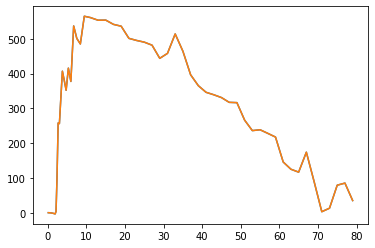

In [12]:
plt.plot(r_xi, r_xi**2*flat_xi_hh_data[-3,:])
plt.plot(r_xi, r_xi**2*xi_hh_data[-1,-1,-3,:])

In [13]:
# Runs to cosmological parameters
cosmo_params = pd.read_csv('/cosma6/data/dp004/dc-cues1/emulator/cosmological_parameters.dat', sep= ' ')

In [14]:
cosmo_params = cosmo_params.iloc[1:]#.reset_index(drop=True)

In [15]:
cosmo_params

,wb,wc,Ol,tau,lnAs,ns,w,s8,Om,h
1,0.021149,0.124951,0.713145,0.068335,3.07544,0.927367,-0.878,0.820884,0.286855,0.715225
2,0.021349,0.114888,0.559839,0.062805,2.59277,0.965947,-0.986,0.603881,0.440161,0.557647
3,0.021416,0.120399,0.754209,0.084135,3.36008,1.004530,-0.910,0.971229,0.245791,0.761299
4,0.021571,0.108659,0.770634,0.054115,3.31058,0.961124,-0.854,0.843781,0.229367,0.755363
5,0.021616,0.113690,0.729570,0.104675,2.53089,0.935083,-0.886,0.587392,0.270429,0.709016
...,...,...,...,...,...,...,...,...,...,...
96,0.022840,0.111534,0.691244,0.101515,2.48139,0.964018,-0.926,0.567620,0.308756,0.661273
97,0.022973,0.119920,0.789798,0.051745,3.34771,0.973663,-0.858,0.926508,0.210203,0.826336
98,0.023107,0.119201,0.570790,0.061225,3.54572,0.990059,-1.038,1.006150,0.429210,0.577103
99,0.023240,0.123514,0.650180,0.071495,2.66703,0.952444,-1.138,0.688576,0.349820,0.649109


In [16]:
cosmo_numbers = [cosmo_number2run[c] for c in range(1,len(xi_hh_data)+1)]
cosmo_params = cosmo_params.loc[cosmo_numbers].reset_index(drop=True).reset_index()


In [17]:
cosmo_params = cosmo_params.loc[cosmo_params.index.repeat(n_snapshots*n_logn)]


In [18]:
flat_df = pd.DataFrame(flat_xi_hh_data,
            columns=[f'xi_{i}' for i in range(len(flat_xi_hh_data.T))])

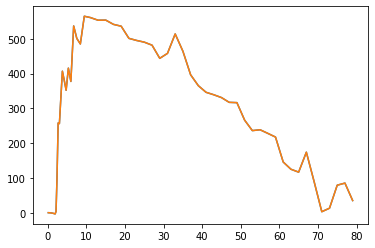

In [19]:
plt.plot(r_xi, r_xi**2*flat_xi_hh_data[-3,:])
plt.plot(r_xi, r_xi**2*flat_df.iloc[-3])


In [20]:
cosmo_params = cosmo_params.reset_index(drop=True)

In [21]:
df = cosmo_params.join(flat_df)


In [22]:
# Add redshift and logn
redshifts = [snapshot_to_redshift(s) for s in range(n_snapshots)]

In [23]:
sampling = len(df) // len(lognh_table)

In [24]:
logn_bin = list(range(len(lognh_table))) * sampling

In [25]:
df['logn_bin'] = logn_bin

In [26]:
df['logn1'] = lognh_table[df['logn_bin'].values][:,0]
df['logn2'] = lognh_table[df['logn_bin'].values][:,1]

In [27]:
redshifts = list(np.repeat(redshifts,len(lognh_table)))*n_runs

In [28]:
df['redshift'] = redshifts

In [29]:
select_columns = [col for col in df.columns if col.startswith('xi_')]


In [30]:
df['index'] +=1 

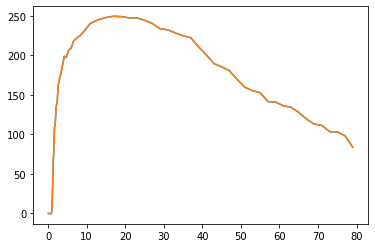

In [31]:
run = 30
snapshot = 3
logn_bin = 26
logn1, logn2 = lognh_table[logn_bin]
plt.plot(r_xi, r_xi**2*xi_hh_data[run-1, snapshot, logn_bin])
plt.plot(r_xi, r_xi**2*df[(df['index'] == run) & (df['redshift'] == snapshot_to_redshift(snapshot))
                          & (df['logn1'] == logn1) & (df['logn2'] == logn2)][select_columns].iloc[0])

In [32]:
xi_fiducial = np.load(HALO_DATA_DIR / "xi/xihh_fiducial.npy")

In [33]:
# In case we are training with non-multioutput -> remove nans completely
# In multioutput? -> Always remove nans

In [34]:
from dark_emulator import darkemu
emu = darkemu.base_class()


initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [44]:
emu.set_cosmology(emu.cosmo.cpara_list[run])

In [45]:
df[df['index'] == run]

,index,wb,wc,Ol,tau,lnAs,ns,w,s8,Om,...,xi_69,xi_70,xi_71,xi_72,xi_73,xi_74,logn_bin,logn1,logn2,redshift
21924,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,NaN,NaN,NaN,NaN,NaN,NaN,0,-2.5,-2.5,1.475701
21925,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,NaN,NaN,NaN,NaN,NaN,NaN,1,-2.5,-3.0,1.475701
21926,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,NaN,NaN,NaN,NaN,NaN,NaN,2,-2.5,-3.5,1.475701
21927,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,NaN,NaN,NaN,NaN,NaN,NaN,3,-2.5,-4.0,1.475701
21928,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,NaN,NaN,NaN,NaN,NaN,NaN,4,-2.5,-4.5,1.475701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22675,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,0.051444,0.051779,0.051175,0.042995,0.040616,0.042994,31,-5.0,-5.5,0.000000
22676,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,0.067157,0.076178,0.066151,0.051692,0.047268,0.045538,32,-5.0,-6.0,0.000000
22677,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,0.047852,0.055311,0.065577,0.051584,0.060994,0.067799,33,-5.5,-5.5,0.000000
22678,30,0.02215,0.117284,0.817174,0.097565,2.9888,1.00067,-1.086,0.856555,0.182826,...,0.072981,0.087094,0.093547,0.068536,0.061996,0.068627,34,-5.5,-6.0,0.000000


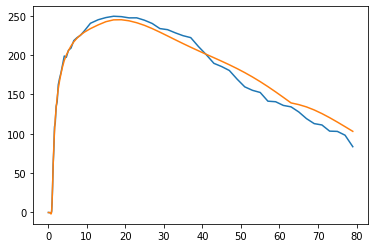

In [46]:
plt.plot(r_xi, r_xi**2*df[(df['index'] == run) & (df['redshift'] == snapshot_to_redshift(snapshot))
                          & (df['logn1'] == logn1) & (df['logn2'] == logn2)][select_columns].iloc[0])
plt.plot(r_xi, r_xi**2* emu.get_xiauto(r_xi, logn1, logn2, snapshot_to_redshift(snapshot)))